<div align="center">
<a href="https://vbti.nl"><img src="https://docs.google.com/uc?export=download&id=1DdCGllL51O5wBuiI0rwygofKx3YIDPHX" width="400"></a>
</div>

# AutoEncoders (AE)
In this notebook you will learn the basics of an **autoencoder (AE)**. The autoencoder architecture was already explored in the 1980s by Geoffrey Hinton as a means to compress high dimensional data. With the recent developments in deep learning technology (e.g. data and computer power availability) autoencoders can now be used on image data.

In the code below we will train an AE for the MNIST dataset.


##Reference
This notebook is based on the following source:

Soon Yau Cheong, hands-On Image Generation with Tensorflow, PacktPublishing, 2020. https://github.com/PacktPublishing/Hands-On-Image-Generation-with-TensorFlow-2.0




<div align=\"center\">
<a href=\"https://vbti.nl\"><img src=\"https://docs.google.com/uc?export=download&id=1DdCGllL51O5wBuiI0rwygofKx3YIDPHX\" width=\"400\"></a>
</div>


In [10]:
# Run the lines below when running this notebook on Google Colab.
!pip3 uninstall tensorflow
!pip3 install tensorflow_gpu==2.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Reshape, Conv2DTranspose, MaxPooling2D, UpSampling2D, LeakyReLU
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
from packaging.version import parse as parse_version
assert parse_version(tf.__version__) < parse_version("2.4.0"), \
    f"Please install TensorFlow version 2.3.1 or older. Your current version is {tf.__version__}."

# Load MNIST dataset
The MNIST dataset is used to train an AE. The pixel values are normalized between 0 and 1.

In [2]:
(ds_train, ds_test_), ds_info = tfds.load('mnist', 
                              split=['train', 'test'], 
                              shuffle_files=True,
                              as_supervised=True,
                              with_info=True)


batch_size = 256
def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = image/255.
    return image, image


ds_train = ds_train.map(preprocess)
ds_train = ds_train.cache() # put dataset into memory
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(batch_size)

ds_test = ds_test_.map(preprocess).batch(batch_size).cache().prefetch(batch_size)



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [3]:
# return label for testing
def preprocess_with_label(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.math.round(image/255.)
    return image, label

ds_test_label = ds_test_.map(preprocess_with_label).batch(1000)

# Building Autoencoder
An AE architecture consists of two parts: the encoder and the decoder. The encoders takes as input an image and processes the image into a so called **latent space vector**. The latent space vector usually as a (much) lower dimension as the input image and is often denoted with the letter *z*.

The decoder part of an AE takes as input a latent space vector *z* and processes it into an image output. The output typically has a (much) larger dimension than the latent space vector dimensionality. This means that the decoder is *upsampling* data.

<div align="center">
<img src="https://drive.google.com/file/d/1r0j5OPQnZUip9h01K4EupnaxUXCy8scY/view" width="400">
</div>



In [4]:
def Encoder(z_dim):
    inputs  = layers.Input(shape=[28,28,1])
    
    x = inputs    
    x = Conv2D(filters=8,  kernel_size=(3,3), strides=2, padding='same', activation='relu')(x)
    x = Conv2D(filters=8,  kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = Conv2D(filters=8,  kernel_size=(3,3), strides=2, padding='same', activation='relu')(x)
    x = Conv2D(filters=8,  kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = Flatten()(x)
    out = Dense(z_dim)(x)
    
    return Model(inputs=inputs, outputs=out, name='encoder')

def Decoder(z_dim):
    inputs  = layers.Input(shape=[z_dim])
    x = inputs    
    x = Dense(7*7*64, activation='relu')(x)
    x = Reshape((7,7,64))(x)

    x = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = UpSampling2D((2,2))(x)
    
    x = Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='relu')(x)
    x = UpSampling2D((2,2))(x)    

    out = Conv2D(filters=1, kernel_size=(3,3), strides=1, padding='same', activation='sigmoid')(x)
    
    #return out          
    return Model(inputs=inputs, outputs=out, name='decoder')

class Autoencoder:
    def __init__(self, z_dim):
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        
        model_input = self.encoder.input
        model_output = self.decoder(self.encoder.output)
        self.model = Model(model_input, model_output)
        


Upon creating an autoencoder network you must specify the latent space dimensionality. The higher the dimensionality, the less information is lost in the encoder-decoder. In the code below you will explore the impact of the dimensionaity on the compression quality and structure of the latent space.

In [5]:
autoencoder = Autoencoder(z_dim=10)


In [7]:
import os

model_path = "./models/autoencoder.h5"
os.makedirs("./models", exist_ok=True)

checkpoint = ModelCheckpoint(model_path, 
                             monitor= "val_loss", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "auto", 
                             save_weights_only = False)

early = EarlyStopping(monitor= "val_loss", 
                      mode= "auto", 
                      patience = 5)

callbacks_list = [checkpoint, early]

autoencoder.model.compile(
    loss = "mse",
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=3e-4))
    #metrics=[tf.keras.losses.BinaryCrossentropy()])
autoencoder.model.fit(ds_train, validation_data=ds_test,
                epochs = 100, callbacks = callbacks_list)

Epoch 1/100
235/235 [==============================] - ETA: 0s - loss: 0.0669
Epoch 00001: val_loss improved from inf to 0.04304, saving model to ./models/autoencoder.h5
235/235 [==============================] - 141s 601ms/step - loss: 0.0669 - val_loss: 0.0430
Epoch 2/100
235/235 [==============================] - ETA: 0s - loss: 0.0369
Epoch 00002: val_loss improved from 0.04304 to 0.03254, saving model to ./models/autoencoder.h5
235/235 [==============================] - 139s 592ms/step - loss: 0.0369 - val_loss: 0.0325
Epoch 3/100
235/235 [==============================] - ETA: 0s - loss: 0.0291
Epoch 00003: val_loss improved from 0.03254 to 0.02690, saving model to ./models/autoencoder.h5
235/235 [==============================] - 139s 591ms/step - loss: 0.0291 - val_loss: 0.0269
Epoch 4/100
235/235 [==============================] - ETA: 0s - loss: 0.0255
Epoch 00004: val_loss improved from 0.02690 to 0.02358, saving model to ./models/autoencoder.h5
235/235 [====================

KeyboardInterrupt: ignored

# Sample and Display Images
Now that the AE with z_dim=10 has been trained, we can compare input images with the reconstructed output images. This is done below.

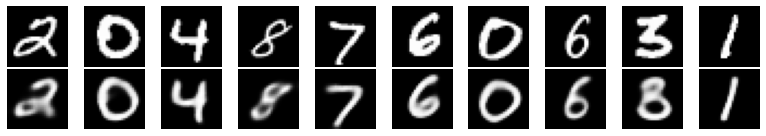

In [8]:
images, labels = next(iter(ds_test))
autoencoder.model = load_model(model_path)
outputs = autoencoder.model.predict(images)

# Display
grid_col = 10
grid_row = 2

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.1, grid_row))

i = 0
for row in range(0, grid_row, 2):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row,col].axis('off')
        axarr[row+1,col].imshow(outputs[i,:,:,0], cmap='gray')
        axarr[row+1,col].axis('off')        
        i += 1
f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)        
plt.show()

## Set z_dim = 2 and to look at the latent variables
To investigate the effect of the latent space dimensionality, we train an AE with z_dim=2. Next, some examples are plotted again.

In [9]:
autoencoder_2 = Autoencoder(z_dim=2)

early = EarlyStopping(monitor= "val_loss", 
                      mode= "auto", 
                      patience = 5)

callbacks_list = [early]

autoencoder_2.model.compile(
    loss = "mse",
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3))

autoencoder_2.model.fit(ds_train, validation_data=ds_test,
                epochs = 5, callbacks = callbacks_list)

Epoch 1/5
235/235 [==============================] - 145s 615ms/step - loss: 0.0622 - val_loss: 0.0521
Epoch 2/5
235/235 [==============================] - 137s 584ms/step - loss: 0.0508 - val_loss: 0.0494
Epoch 3/5
235/235 [==============================] - 135s 575ms/step - loss: 0.0486 - val_loss: 0.0501
Epoch 4/5
235/235 [==============================] - 133s 567ms/step - loss: 0.0473 - val_loss: 0.0468
Epoch 5/5
235/235 [==============================] - 134s 568ms/step - loss: 0.0464 - val_loss: 0.0463


A nice feature of z_dim=2 is that we can actually create a scatter plot of the the latent space. To do this, we input many images from the MNIST dataset to the encoder and calculate the corresponding 2D latent space vector. A scatter plot of these vectors is made below. The color of a point relates the the class (number) of the MNIST digit sample.

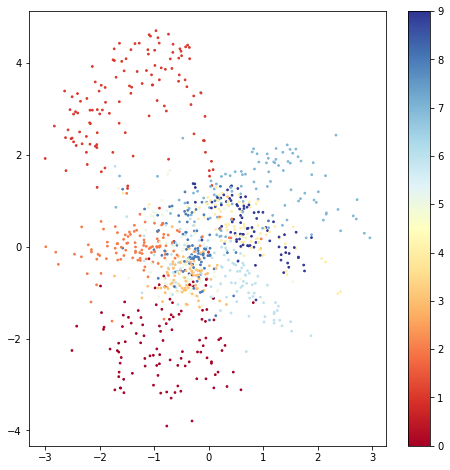

In [11]:
images, labels = next(iter(ds_test_label))
outputs = autoencoder_2.encoder.predict(images)
plt.figure(figsize=(8,8))
plt.scatter(outputs[:,0], outputs[:,1], c=labels, cmap='RdYlBu', s=3)
plt.colorbar()

The structure of the latent space can also be visualized by plotting a matrix with reconstructed images using the latent vector that corresponds with the position in the matrix.

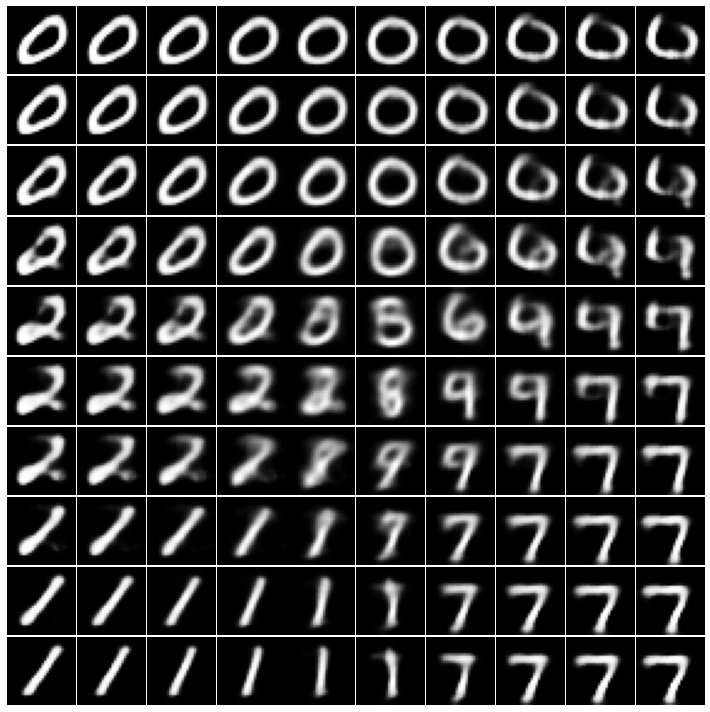

In [12]:
z_samples = np.array([[z1, z2] for z2 in np.arange(-5, 5, 1.) for z1 in np.arange(-5, 5, 1.)])
images = autoencoder_2.decoder.predict(z_samples)
grid_col = 10
grid_row = 10

f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col, grid_row))

i = 0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row,col].axis('off')   
        i += 1
f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)        
plt.show() 

Finally, to explore the latent space, below an interactive dashboard is made with two sliders, for every dimension one.

In [13]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [14]:
@interact
def explore_latent_variable(z1 = (-5,5,0.1),
                            z2 = (-5,5,0.1)):
    z_samples = [[z1, z2]]
    images = autoencoder_2.decoder.predict(z_samples)
    plt.figure(figsize=(2,2))
    plt.imshow(images[0,:,:,0], cmap='gray')

interactive(children=(FloatSlider(value=0.0, description='z1', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…